## Using Apache Spark for Data Processing and Machine Learning  to detect nature of physical activity using sensor data.

The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities, performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor.

We will load the data into Hadoop ditributed file system and utilize pyspark to process the data and use mlib library in pyspark for machine learning algorithms to detect the physical activity based on readings.



#### Raw data format

## Move Rawdata to HDFS and Convert into ORC format

Follow the below steps to download and move raw data from local file system to hdfs and convert into orc format for distributed processing


###### Download the dataset

###### Create directory in HDFS and copy files from local to HDFS

###### Create HIVE external Table with schema and Load data


The import can be verified by listing the first few rows in the table:

###### Create a HIVE managed ORC table to convert into orc format

###### Insert the data from the external table into the Hive-managed table.

Verify the data import into ORC-formatted table: 


Successfuly converted into ORC format

In [ ]:
hive> describe formatted test1.pamap2_orc;
OK
# col_name              data_type               comment

time                    double
activity                double
heart_rate              double
hand_temp               double
hand_acc16g_1           double
hand_acc16g_2           double
.                       .
.                       .
.                       . 

ankle_orient_3          double
ankle_orient_4          double

# Detailed Table Information
Database:               test1
Owner:                  hadoop
CreateTime:             Thu Mar 14 09:24:11 UTC 2018
LastAccessTime:         UNKNOWN
Retention:              0
Location:               hdfs://test-ser-vm01:9000/user/hive/warehouse/test1.db/pamap2_orc
Table Type:             MANAGED_TABLE
Table Parameters:
        COLUMN_STATS_ACCURATE   {\"BASIC_STATS\":\"true\"}
        numFiles                9
        numRows                 2872533
        rawDataSize             1240934256
        totalSize               772975987
        transient_lastDdlTime   1552555601

# Storage Information
SerDe Library:          org.apache.hadoop.hive.ql.io.orc.OrcSerde
InputFormat:            org.apache.hadoop.hive.ql.io.orc.OrcInputFormat
OutputFormat:           org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat
Compressed:             No
Num Buckets:            -1
Bucket Columns:         []
Sort Columns:           []
Storage Desc Params:
        serialization.format    1
Time taken: 0.604 seconds, Fetched: 83 row(s)


## Pyspark for data processing and Machine Learning

Utilize SparkSQL and ml library to perform data pre-processing steps and machine learning to perform classification,

###### Importing necessary modules

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import pyspark.sql.functions as fn
from pyspark.ml.classification import RandomForestClassifier 
from pyspark.ml.clustering import KMeans,BisectingKMeans
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorAssembler,PCA as sparkpca,MinMaxScaler as sparkMinMaxScaler,Normalizer,VectorIndexer
from pyspark.ml import Pipeline as SparkPipeline,PipelineModel
import pandas as pd
from matplotlib import pyplot as plt
from pyspark.sql.types import DateType
from pyspark.ml.evaluation import RegressionEvaluator,MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import *
from datetime import datetime
import numpy as np
%matplotlib inline  
from pyspark.sql.types import *
from pyspark.sql.functions import array, explode, lit
import warnings
from operator import add
import re
from functools import reduce
warnings.filterwarnings('ignore')

###### Creating SparkSession object and reading orc input file

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
inputdataraw = spark.read.orc('/user/hive/warehouse/test1.db/pamap2_orc')

In [4]:
inputdataraw.cache()
inputdataraw.count()

2872533

In [5]:
inputdataraw.groupBy('activity').agg(fn.count('time')).show()

+--------+-----------+
|activity|count(time)|
+--------+-----------+
|     0.0|     929661|
|     7.0|     188107|
|     1.0|     192523|
|     4.0|     238761|
|     3.0|     189931|
|     2.0|     185188|
|    17.0|     238690|
|    13.0|     104944|
|     6.0|     164600|
|    24.0|      49360|
|     5.0|      98199|
|    16.0|     175353|
|    12.0|     117216|
+--------+-----------+



In [6]:
inputdataraw.printSchema()

root
 |-- time: double (nullable = true)
 |-- activity: double (nullable = true)
 |-- heart_rate: double (nullable = true)
 |-- hand_temp: double (nullable = true)
 |-- hand_acc16g_1: double (nullable = true)
 |-- hand_acc16g_2: double (nullable = true)
 |-- hand_acc16g_3: double (nullable = true)
 |-- hand_acc6g_1: double (nullable = true)
 |-- hand_acc6g_2: double (nullable = true)
 |-- hand_acc6g_3: double (nullable = true)
 |-- hand_gyro_1: double (nullable = true)
 |-- hand_gyro_2: double (nullable = true)
 |-- hand_gyro_3: double (nullable = true)
 |-- hand_mag_1: double (nullable = true)
 |-- hand_mag_2: double (nullable = true)
 |-- hand_mag_3: double (nullable = true)
 |-- hand_orient_1: double (nullable = true)
 |-- hand_orient_2: double (nullable = true)
 |-- hand_orient_3: double (nullable = true)
 |-- hand_orient_4: double (nullable = true)
 |-- chest_temp: double (nullable = true)
 |-- chest_acc16g_1: double (nullable = true)
 |-- chest_acc16g_2: double (nullable = true)


In [10]:
inputdataraw.describe().toPandas()

,summary,time,activity,heart_rate,hand_temp,hand_acc16g_1,hand_acc16g_2,hand_acc16g_3,hand_acc6g_1,hand_acc6g_2,...,ankle_gyro_1,ankle_gyro_2,ankle_gyro_3,ankle_mag_1,ankle_mag_2,ankle_mag_3,ankle_orient_1,ankle_orient_2,ankle_orient_3,ankle_orient_4
0,count,2872533,2872533,2872533,2872533,2872533,2872533,2872533,2872533,2872533,...,2872533,2872533,2872533,2872533,2872533,2872533,2872533,2872533,2872533,2872533
1,mean,1834.3538678511266,5.4662425114002176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,stddev,1105.6889982931357,6.331333413102728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,min,5.64,0.0,57.0,24.75,-145.367,-104.301,-101.452,-61.4895,-61.868,...,-23.995,-18.1269,-14.0196,-172.865,-137.908,-109.289,-0.253628,-0.956876,-0.876838,-0.997281
4,max,4475.63,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
inputdataraw.show(1)

+----+--------+----------+---------+-------------+-------------+-------------+------------+------------+------------+-----------+-----------+-----------+----------+----------+----------+-------------+-------------+-------------+-------------+----------+--------------+--------------+--------------+-------------+-------------+-------------+------------+------------+------------+-----------+-----------+-----------+--------------+--------------+--------------+--------------+----------+--------------+--------------+--------------+-------------+-------------+-------------+------------+------------+------------+-----------+-----------+-----------+--------------+--------------+--------------+--------------+
|time|activity|heart_rate|hand_temp|hand_acc16g_1|hand_acc16g_2|hand_acc16g_3|hand_acc6g_1|hand_acc6g_2|hand_acc6g_3|hand_gyro_1|hand_gyro_2|hand_gyro_3|hand_mag_1|hand_mag_2|hand_mag_3|hand_orient_1|hand_orient_2|hand_orient_3|hand_orient_4|chest_temp|chest_acc16g_1|chest_acc16g_2|chest_ac

Referring to the activity id mappings we can infer that activity id = 0 should not be considered for the analysis as it indicates transient movement between different activities.Lets filter them out.

In [27]:
inputdataraw = inputdataraw.withColumn('new_time',fn.round(fn.col('time')%10))

In [28]:
inputdata = inputdataraw.filter(fn.col('activity')!=0)

In [31]:
inputdata = inputdata.withColumn('activity',fn.col('activity').cast('int'))

In [32]:
inputdata.select('activity').distinct().orderBy('activity').show()

+--------+
|activity|
+--------+
|       1|
|       2|
|       3|
|       4|
|       5|
|       6|
|       7|
|      12|
|      13|
|      16|
|      17|
|      24|
+--------+



We know that heart rate would be considered as an important measure to identify the nature of physical activity,lets group the data by activity and check mean within each group to identify any pattern and validate our hypothesis

In [15]:
heart_rate_agg = inputdata.filter(~fn.isnan('heart_rate')).groupBy('activity').agg(fn.mean('heart_rate').alias('avg_heart_rate'))
heart_rate_agg.sort(fn.desc('avg_heart_rate')).show()

+--------+------------------+
|activity|    avg_heart_rate|
+--------+------------------+
|      24|161.98139122729287|
|       5|156.59581411049848|
|      12|129.52348491922683|
|      13|129.15417491921193|
|       6| 124.8799521403882|
|       7|123.82870101174555|
|       4|112.78986505095016|
|      16| 104.1980908410282|
|      17| 90.06959118052366|
|       3| 88.55763688760807|
|       2| 80.01258195995038|
|       1| 75.53568181818181|
+--------+------------------+



Indeed low intensity activities and high intensity activities have varying heart rates as expected.

##### Checking and treating for Null values

In [33]:
from functools import reduce
null_counts =reduce(lambda x,y:x.union(y),(inputdata.agg(fn.count(fn.when(fn.isnan(c), c)).alias('null_count')).select(fn.lit(c).alias('col_name'),'null_count') for c in inputdata.columns))

Missing sensory data due to wireless data dropping: missing values are indicated with NaN.It is a case of missingness completely at random.

In [14]:
null_counts.sort(fn.desc('null_count')).show(100)

+--------------+----------+
|      col_name|null_count|
+--------------+----------+
|    heart_rate|   1765464|
| hand_acc16g_2|     11124|
| hand_orient_4|     11124|
| hand_orient_1|     11124|
|    hand_mag_1|     11124|
|  hand_acc6g_3|     11124|
|  hand_acc6g_2|     11124|
|     hand_temp|     11124|
|   hand_gyro_2|     11124|
| hand_orient_3|     11124|
| hand_acc16g_1|     11124|
| hand_acc16g_3|     11124|
| hand_orient_2|     11124|
|   hand_gyro_3|     11124|
|  hand_acc6g_1|     11124|
|   hand_gyro_1|     11124|
|    hand_mag_3|     11124|
|    hand_mag_2|     11124|
|ankle_orient_1|      8507|
| ankle_acc6g_2|      8507|
|ankle_orient_4|      8507|
|  ankle_gyro_2|      8507|
|ankle_acc16g_1|      8507|
|   ankle_mag_1|      8507|
|ankle_orient_3|      8507|
|ankle_acc16g_2|      8507|
|ankle_acc16g_3|      8507|
|  ankle_gyro_3|      8507|
|ankle_orient_2|      8507|
| ankle_acc6g_3|      8507|
|   ankle_mag_3|      8507|
|   ankle_mag_2|      8507|
| ankle_acc6g_1|    

As we know the sensory data is time framed we can forward-fill and backward-fill null values using SparkSQL Window function - partition by activity and order by time

In [152]:
for column in inputdata.columns:
    inputdata = inputdata.withColumn(column,fn.when(fn.isnan(fn.col(column)),None).otherwise(fn.col(column)))


In [79]:
from pyspark.sql import Window
import sys

window_ffill = Window.partitionBy('activity').orderBy('time').rowsBetween(-sys.maxsize,0)
window_bfill = Window.partitionBy('activity').orderBy('time').rowsBetween(0,sys.maxsize)

for c in [x for x in inputdata.columns if x not in ['time','activity']]:
    inputdata = inputdata.withColumn(c,fn.last(fn.col(c),ignorenulls=True).over(window_ffill))
    
for c in [x for x in inputdata.columns if x not in ['time','activity']]:
    inputdata = inputdata.withColumn(c,fn.last(fn.col(c),ignorenulls=True).over(window_bfill))

In [20]:
null_counts_check =reduce(lambda x,y:x.union(y),(inputdata.agg(fn.count(fn.when(fn.isnull(c), c)).alias('null_count')).select(fn.lit(c).alias('col_name'),'null_count') for c in inputdata.columns))

In [21]:
null_counts_check.sort(fn.desc('null_count')).show()

+--------------+----------+
|      col_name|null_count|
+--------------+----------+
|ankle_acc16g_3|         0|
|     hand_temp|         0|
| ankle_acc6g_1|         0|
| hand_orient_2|         0|
|chest_acc16g_1|         0|
|  ankle_gyro_1|         0|
|   hand_gyro_3|         0|
| ankle_acc6g_3|         0|
| hand_orient_3|         0|
|   ankle_mag_3|         0|
|      activity|         0|
|   chest_mag_2|         0|
|chest_orient_2|         0|
| ankle_acc6g_2|         0|
|ankle_acc16g_1|         0|
| chest_acc6g_3|         0|
|  chest_gyro_1|         0|
| hand_acc16g_1|         0|
|  chest_gyro_2|         0|
| chest_acc6g_2|         0|
+--------------+----------+
only showing top 20 rows



###### Feature engineering

For each body sensor measurement available lets compare each value and generate aggregated features such as mean,standard deviation,min,max,max-min etc.

In [39]:
##feature engineering
hand_cols = [col for col in inputdata.columns if re.search(r"hand",col)]
chest_cols = [col for col in inputdata.columns if re.search(r"chest",col)]
ankle_cols = [col for col in inputdata.columns if re.search(r"ankle",col)]
sensor_cols = ['temp',
 'acc16g_1',
 'acc16g_2',
 'acc16g_3',
 'acc6g_1',
 'acc6g_2',
 'acc6g_3',
 'gyro_1',
 'gyro_2',
 'gyro_3',
 'mag_1',
 'mag_2',
 'mag_3',
 'orient_1',
 'orient_2',
 'orient_3',
 'orient_4']


for col_nm,a,b,c in zip(sensor_cols,hand_cols,chest_cols,ankle_cols):
    inputdata = inputdata.withColumn(col_nm+'all_sum',fn.col(a)+fn.col(b)+fn.col(c))
    inputdata = inputdata.withColumn(col_nm+'all_max',fn.greatest(fn.col(a),fn.col(b),fn.col(c)))
    inputdata = inputdata.withColumn(col_nm+'all_min',fn.least(fn.col(a),fn.col(b),fn.col(c)))
    inputdata = inputdata.withColumn(col_nm+'all_max-min',fn.col(col_nm+'all_max')-fn.col(col_nm+'all_min'))
    inputdata = inputdata.withColumn(col_nm+'all_mean',fn.col(col_nm+'all_sum')/3)
    inputdata = inputdata.withColumn(col_nm+'all_std',fn.sqrt(reduce(add, ((fn.col(x) - fn.col(col_nm+'all_mean')) ** 2 for x in [a,b,c])) /2))
    

###### Preparing target variable

From the activity list we can group the activities based on the intensity of the physical activity carried out into minimal,low,medium,high intensity bins for classification purpose.

In [40]:
#Minimun: [lying,sitting,standing,computer work,car driving,folding laundry]
minimum_activity = [1,2,3,9,10,11,18]
#Low: [descending stairs, ironing, house cleaning]
low_activity = [13,17,19]
#medium: [walking,descending stairs,vacuum cleaning]
medium_activity =  [4,12,16]
#high: [running,cycling,nordic walking,playing soccer,rope jumping]
high_activity = [5,6,7,20,24]

In [41]:
##target labels

inputdata = inputdata.withColumn('target',fn.when(fn.col('activity').isin(minimum_activity),'min'))
inputdata = inputdata.withColumn('target',fn.when(fn.col('activity').isin(low_activity),'low').otherwise(fn.col('target')))
inputdata = inputdata.withColumn('target',fn.when(fn.col('activity').isin(medium_activity),'medium').otherwise(fn.col('target')))
inputdata = inputdata.withColumn('target',fn.when(fn.col('activity').isin(high_activity),'high').otherwise(fn.col('target')))


In [15]:

inputdata.select(fn.col('target')).distinct().show()

+------+
|target|
+------+
|   low|
|  high|
|medium|
|   min|
+------+



Perform label indexing for each target variable

In [42]:
inputdata = inputdata.withColumn('label',fn.when(fn.col('target')=='min',0))
inputdata = inputdata.withColumn('label',fn.when(fn.col('target')=='low',1).otherwise(fn.col('label')))
inputdata = inputdata.withColumn('label',fn.when(fn.col('target')=='medium',2).otherwise(fn.col('label')))
inputdata = inputdata.withColumn('label',fn.when(fn.col('target')=='high',3).otherwise(fn.col('label')))
                                 


## Machine Learning using pyspark

Utlizing machine learning to detect the intensity of physical activity using the readings of wearable devices that can track body motions and basic physiological parameters such as heart rate,temperature,acceleration,gyro,orientation parameters of different parts of the body.

Now we have our data processing and transformation using SparkSQL completed,lets perform machine learning using Pyspark ml library

In [43]:
inputdata.cache()
inputdata.count()

1942872

In [64]:
inputdata.select('target','label').distinct().show()

+------+-----+
|target|label|
+------+-----+
|  high|    3|
|   min|    0|
|   low|    1|
|medium|    2|
+------+-----+



###### Preparing train/test data and features/target

In [65]:
train,test = inputdata.randomSplit([0.8, 0.2])

In [66]:
features = ['heart_rate','hand_temp','hand_acc16g_1','hand_acc16g_2','hand_acc16g_3','hand_acc6g_1','hand_acc6g_2','hand_acc6g_3','hand_gyro_1',
'hand_gyro_2','hand_gyro_3','hand_mag_1','hand_mag_2','hand_mag_3','hand_orient_1','hand_orient_2','hand_orient_3','hand_orient_4',
'chest_temp','chest_acc16g_1','chest_acc16g_2','chest_acc16g_3','chest_acc6g_1','chest_acc6g_2','chest_acc6g_3','chest_gyro_1',
'chest_gyro_2','chest_gyro_3','chest_mag_1','chest_mag_2','chest_mag_3','chest_orient_1','chest_orient_2','chest_orient_3',
'chest_orient_4','ankle_temp','ankle_acc16g_1','ankle_acc16g_2','ankle_acc16g_3','ankle_acc6g_1','ankle_acc6g_2','ankle_acc6g_3',
'ankle_gyro_1','ankle_gyro_2','ankle_gyro_3','ankle_mag_1','ankle_mag_2','ankle_mag_3','ankle_orient_1','ankle_orient_2',
'ankle_orient_3','ankle_orient_4','tempall_sum','tempall_max','tempall_min','tempall_max-min','tempall_mean',
'tempall_std','acc16g_1all_sum','acc16g_1all_max','acc16g_1all_min','acc16g_1all_max-min','acc16g_1all_mean','acc16g_1all_std',
'acc16g_2all_sum','acc16g_2all_max','acc16g_2all_min','acc16g_2all_max-min','acc16g_2all_mean','acc16g_2all_std','acc16g_3all_sum',
'acc16g_3all_max','acc16g_3all_min','acc16g_3all_max-min','acc16g_3all_mean','acc16g_3all_std','acc6g_1all_sum','acc6g_1all_max',
'acc6g_1all_min','acc6g_1all_max-min','acc6g_1all_mean','acc6g_1all_std','acc6g_2all_sum','acc6g_2all_max','acc6g_2all_min',
'acc6g_2all_max-min','acc6g_2all_mean','acc6g_2all_std','acc6g_3all_sum','acc6g_3all_max','acc6g_3all_min','acc6g_3all_max-min',
'acc6g_3all_mean','acc6g_3all_std','gyro_1all_sum','gyro_1all_max','gyro_1all_min','gyro_1all_max-min','gyro_1all_mean','gyro_1all_std',
'gyro_2all_sum','gyro_2all_max','gyro_2all_min','gyro_2all_max-min','gyro_2all_mean','gyro_2all_std','gyro_3all_sum','gyro_3all_max',
'gyro_3all_min','gyro_3all_max-min','gyro_3all_mean','gyro_3all_std','mag_1all_sum','mag_1all_max','mag_1all_min','mag_1all_max-min',
'mag_1all_mean','mag_1all_std','mag_2all_sum','mag_2all_max','mag_2all_min','mag_2all_max-min','mag_2all_mean','mag_2all_std',
'mag_3all_sum','mag_3all_max','mag_3all_min','mag_3all_max-min','mag_3all_mean','mag_3all_std','orient_1all_sum','orient_1all_max',
'orient_1all_min','orient_1all_max-min','orient_1all_mean','orient_1all_std','orient_2all_sum','orient_2all_max','orient_2all_min',
'orient_2all_max-min','orient_2all_mean','orient_2all_std','orient_3all_sum','orient_3all_max','orient_3all_min','orient_3all_max-min',
'orient_3all_mean','orient_3all_std','orient_4all_sum','orient_4all_max','orient_4all_min','orient_4all_max-min','orient_4all_mean',
'orient_4all_std']

target = 'label'

###### Random forest with Cross-validation using Pyspark

In [71]:
def spark_rf_classifier(train, test,features,label):

    mlassembler = VectorAssembler(inputCols=features,outputCol="features")
    rf = RandomForestClassifier(labelCol = label, featuresCol="features")

    rfpipeline = SparkPipeline(stages=[mlassembler,rf])
    rfparamGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5,10,20]).addGrid(rf.numTrees, [100,250,500]).build()
    rfevaluator = MulticlassClassificationEvaluator(labelCol =label,predictionCol = "prediction",metricName = "accuracy")
    rfcrossval = CrossValidator(estimator=rfpipeline,
                              estimatorParamMaps=rfparamGrid,
                              evaluator=rfevaluator,
                              numFolds=3,parallelism=5) 

    rfmodel = rfcrossval.fit(train)
    rfpredict = rfmodel.transform(test) 
    rf_accuracy = rfevaluator.evaluate(rfpredict,{rfevaluator.metricName: "accuracy"})
    rf_precision = rfevaluator.evaluate(rfpredict,{rfevaluator.metricName: "weightedPrecision"})
    rf_recall = rfevaluator.evaluate(rfpredict,{rfevaluator.metricName: "weightedRecall"})
    rf_f1 = rfevaluator.evaluate(rfpredict,{rfevaluator.metricName: "f1"})
    return ("Random Forest Model",rfmodel,rfpredict,rf_accuracy,rf_precision,rf_recall,rf_f1,rfevaluator,rfcrossval)

In [72]:
result = spark_rf_classifier(train, test,features,target)


In [91]:
print(result[1])
best_pipeline = result[1].bestModel
print(best_pipeline)
best_pipeline.stages

CrossValidatorModel_4b37928f1bbcf19ad86d
PipelineModel_474599db674a829f00e6


[VectorAssembler_409d85531cdc48ea7dd4,
 RandomForestClassificationModel (uid=RandomForestClassifier_410bbd81e41f7e012fe4) with 100 trees]

From the cross-validation mechanism we have our best Random forest model,lets check the best paramters of the model

In [92]:
best_rf_model = best_pipeline.stages[1]

In [124]:
best_rf_model.getNumTrees

100

In [113]:
rf = RandomForestClassifier(labelCol = 'label', featuresCol="features")
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5,10,20]).addGrid(rf.numTrees, [100,250,500]).build()
java_model = best_rf_model._java_obj
{param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid[0]}

{'maxDepth': 20, 'numTrees': 100}

We have performed hyperparameter tuning for the random forest model and indentified the hyperparameter with best validation metrics.    


###### Training model and saving for prediction

In [127]:
mlassembler = VectorAssembler(inputCols=features,outputCol="features")
final_rf = RandomForestClassifier(maxDepth=20,numTrees=100,labelCol = 'label', featuresCol="features")
final_rfpipeline = SparkPipeline(stages=[mlassembler,final_rf])
final_rf_model = final_rfpipeline.fit(train)

In [128]:
final_rf_model.write().overwrite().save('/mnt/data/scripts/notebooks/ashwin/models/final_rf_model_trained')

In [129]:
model = PipelineModel.load('/mnt/data/scripts/notebooks/ashwin/models/final_rf_model_trained')
preds = model.transform(test)

In [131]:
preds.groupBy('label','prediction').count().show()


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    0|       0.0|113181|
|    1|       2.0|   250|
|    2|       3.0|     1|
|    3|       2.0|    44|
|    3|       3.0| 99606|
|    2|       2.0|106191|
|    1|       1.0| 68570|
+-----+----------+------+



As we can see most of the actual label and predictions are accurate and only a few are misclassified.This is a very good performing model for this classification purpose.

###### Extracting Feature importances

In [134]:
feat_imp = model.stages[-1].featureImportances

In [136]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [137]:
feature_importances = ExtractFeatureImp(feat_imp,predictions,"features")

In [141]:
feat_imp_df = pd.DataFrame(feature_importances).sort_values(by=['score'],ascending=False)
feat_imp_df.head()

,idx,name,score
0,0,heart_rate,0.155386
52,52,tempall_sum,0.039391
1,1,hand_temp,0.036727
54,54,tempall_min,0.035904
18,18,chest_temp,0.034430


In [144]:
feat_imp_df.drop(columns=['idx'],inplace=True)
feat_imp_df.set_index('name',inplace=True)


Text(0.5,1,'Feature Importances')

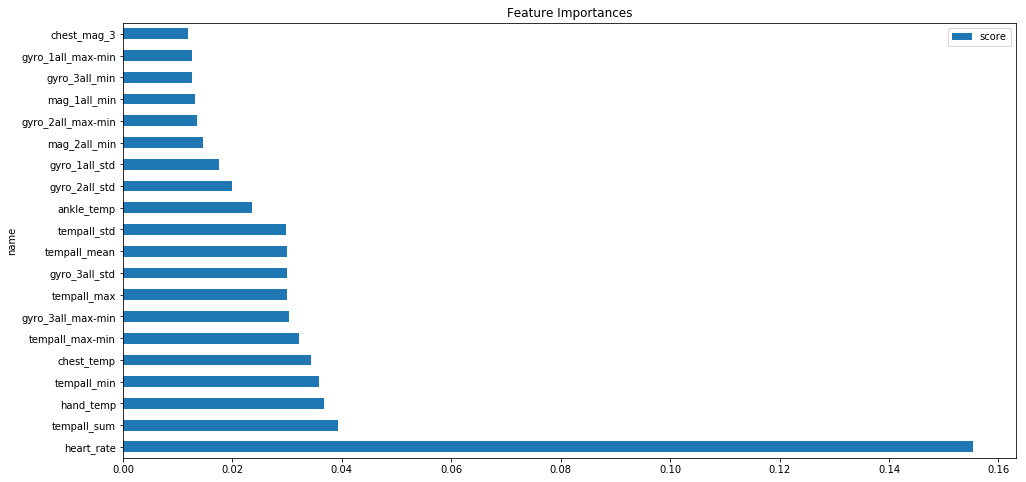

In [148]:
feat_imp_df.head(20).plot(kind='barh',figsize=(16,8))
plt.title('Feature Importances')

As we can see from the feature importances extracted heart rate and temperature related features play an important role in classification trees.Overall we can see the engineered features have good feature importances in our model compared to the original features.

In [151]:
eval_rf = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
eval_rf.evaluate(preds)

1.0